In [8]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD


# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [9]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [10]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [11]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [12]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [13]:
def without_news(df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['Adj Close']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]

  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=10, batch_size=32)

  plot_training_loss(hist)
 

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")


  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)

In [14]:
df_name = "source_price.csv"
df = pd.read_csv(df_name, index_col=0)
df['date'] = df.index
df = df.reset_index(drop=True)
df

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,date
0,0.296000,-0.136600,0.000000,0.000000,2636.979980,2017/12/7
1,0.000000,0.000000,-0.242300,0.000000,2651.500000,2017/12/8
2,0.000000,0.000000,0.000000,0.000000,2659.989990,2017/12/11
3,0.000000,0.000000,0.000000,0.000000,2664.110107,2017/12/12
4,0.000000,0.000000,0.000000,0.000000,2662.850098,2017/12/13
...,...,...,...,...,...,...
116,0.030290,0.047433,0.011550,-0.025190,2721.330078,2018/5/25
117,-0.052796,0.070442,-0.025721,-0.035568,2689.860107,2018/5/29
118,-0.017367,0.038119,-0.076965,-0.063177,2724.010010,2018/5/30
119,-0.018636,0.057371,-0.064138,-0.025489,2705.270020,2018/5/31


y_test_original.shape (9, 1)
Epoch 1/10
3/3 [==============================] - 3s 16ms/step - loss: 0.3574 - mean_squared_error: 0.3574
Epoch 2/10
3/3 [==============================] - 0s 15ms/step - loss: 0.2816 - mean_squared_error: 0.2816
Epoch 3/10
3/3 [==============================] - 0s 14ms/step - loss: 0.2626 - mean_squared_error: 0.2626
Epoch 4/10
3/3 [==============================] - 0s 14ms/step - loss: 0.2248 - mean_squared_error: 0.2248
Epoch 5/10
3/3 [==============================] - 0s 14ms/step - loss: 0.2085 - mean_squared_error: 0.2085
Epoch 6/10
3/3 [==============================] - 0s 14ms/step - loss: 0.1758 - mean_squared_error: 0.1758
Epoch 7/10
3/3 [==============================] - 0s 14ms/step - loss: 0.1702 - mean_squared_error: 0.1702
Epoch 8/10
3/3 [==============================] - 0s 15ms/step - loss: 0.1611 - mean_squared_error: 0.1611
Epoch 9/10
3/3 [==============================] - 0s 14ms/step - loss: 0.1452 - mean_squared_error: 0.1452
Epoch 10

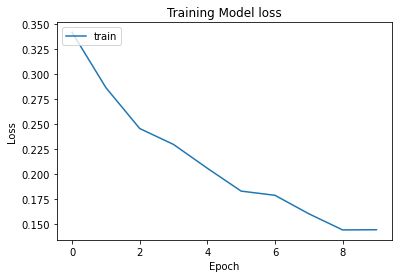

        date       Actual    Predicted
0  2018/5/21  2712.969971  [2694.9062]
1  2018/5/22  2733.010010   [2696.152]
2  2018/5/23  2724.439941  [2711.7605]
3  2018/5/24  2733.290039  [2720.9536]
4  2018/5/25  2727.760010  [2721.7825]
5  2018/5/29  2721.330078  [2722.2058]
6  2018/5/30  2689.860107  [2708.4922]
7  2018/5/31  2724.010010  [2710.4497]
8   2018/6/1  2705.270020  [2710.0364]

-----Model Evaluation-----------------------------------------------------

1/1 - 1s - loss: 0.1136 - mean_squared_error: 0.1136
LSTM Model Loss =  [0.11363237351179123, 0.11363237351179123]
Model Accuracy =  [99.49454]
Mean Absolute Error =  13.74994581423612  degrees
Mean Squared Error =  287.55683670574274
Root Mean Squared Error =  16.95750089800212

--------------------------------------------------------------------------



In [15]:
hist, model, df_compare, Accuracy, MAE, MSE, RMSE = without_news(df)